In [1]:
# 🚨 RESETEAR TODO PARA PARTIR LIMPIO EN COLAB

import os, shutil

# 1) Ir a /content
%cd /content

# 2) Borrar cualquier clone previo duplicado
if os.path.exists("proyecto_aplicado_preservantes"):
    shutil.rmtree("proyecto_aplicado_preservantes")
    print("🗑️ Carpeta borrada: proyecto_aplicado_preservantes")

# 3) Clonar de nuevo desde tu GitHub
!git clone https://github.com/nalpata/proyecto_aplicado_preservantes.git

# 4) Entrar a la carpeta correcta
%cd proyecto_aplicado_preservantes

print("\n🎉 Listo. Ahora estamos en el repo correcto sin duplicados.")
!ls


/content
Cloning into 'proyecto_aplicado_preservantes'...
remote: Enumerating objects: 100, done.
remote: Counting objects: 100% (100/100), done.
remote: Compressing objects: 100% (89/89), done.
remote: Total 100 (delta 24), reused 77 (delta 10), pack-reused 0 (from 0)
Receiving objects: 100% (100/100), 19.27 MiB | 19.01 MiB/s, done.
Resolving deltas: 100% (24/24), done.
/content/proyecto_aplicado_preservantes

🎉 Listo. Ahora estamos en el repo correcto sin duplicados.
 CHECKLIST_INSTALACION.md   notebooks		   run_pipeline.py
 data			   'Pauta proyecto.pdf'    SOLUCION_INSTALACION.md
 DIAGRAMAS_HITO_1.md	    PROBLEMAS_COMUNES.md   src
 examples.py		    QUICK_START.md	   streamlit_app.py
 FIX_CHROMADB.md	    README.md		   test_improvements.py
 install_dependencies.sh    requirements.txt	   TESTING_LOCAL.md
 install_fix.sh		    RESUMEN_FINAL.md	   test_single_pdf.py
 INSTRUCCIONES_PRUEBA.md    RESUMEN_HITO_1.md
 MEJORAS_CHUNKING.md	    RESUMEN_PROBLEMAS.md


# Lesson 2: Document Chunking Strategies

**Objective**: Learn how to effectively segment documents for better retrieval performance.

**Topics**:

- Chunking techniques: token-level, sentence-level, semantic-level
- Balancing context preservation with retrieval precision
- Small2Big and sliding window techniques

**Practical Task**: Implement chunking strategies on a sample dataset.

**Resources**:
- The five levels of chunking
- A guide to chunking
- [Visualizing chunking](https://chunkviz.up.railway.app/)
- [Full stack retrieval](https://github.com/FullStackRetrieval-com/RetrievalTutorials/blob/a4570f3c4883eb9b835b0ee18990e62298f518ef/tutorials/LevelsOfTextSplitting/5_Levels_Of_Text_Splitting.ipynb)

## Data loading, Chunking techniques and Text processing


### Level 1 - Character splitting

This is the simplest and most basic *chunking* method, it is the process by which we only divide the text into *chunks* of size *N* characters regardless of their content or form.

This method is **NOT** recommended for any application, but it can be a good starting point to understand the fundamentals.

- Pros: easy and fast
- Cons: Very rigid and does not take into account the structure of the text

Concepts:

- **Chunk size**: The number of characters that defines the length of the chunk.
- **Chunk overlap**: The amount of characters that must overlap in sequential chunks. This is to avoid cutting the context into multiple parts, losing the semantic meaning of some passage. This will create duplicates between chunks.

#### Manual example

In [2]:
from pprint import pprint

In [3]:
text = "This is the text I would like to chunk up. It is the example text for this exercise"

# Create an empty list to store the chunks
chunks = []

# Define the chunk size
chunk_size = 35

# Iterate through the text in chunk_size ranges
for i in range(0, len(text), chunk_size):
    chunk = text[i:i + chunk_size]
    chunks.append(chunk)
chunks

['This is the text I would like to ch',
 'unk up. It is the example text for ',
 'this exercise']

In [4]:
len(chunks[0])

35

#### Using the LangChain framework

- Normally for RAG applications we don't work with strings, we work with **Document** type objects. These objects contain the text we want but also contain additional metadata that allows for more complex filtering.

In [5]:
from langchain_text_splitters import CharacterTextSplitter

We load the LangChain text splitter, we need to specify the chunk overlap and separator, if we don't provide them we will have unwanted results.

In [6]:
# Sin overlap
text_splitter = CharacterTextSplitter(
                    chunk_size = 35,
                    chunk_overlap=0,
                    separator='',
                    strip_whitespace=True)

In [7]:
text_splitter.create_documents([text])

[Document(metadata={}, page_content='This is the text I would like to ch'),
 Document(metadata={}, page_content='unk up. It is the example text for'),
 Document(metadata={}, page_content='this exercise')]

![image.png](attachment:image.png)

If we observe, we achieved the same result as with the manual option, but now we have data structures that are compatible with the rest of the framework. Additionally, we were able to do some string cleaning, in the case of the whitespace on the second line, using strip_whitespace=True.

In [8]:
# Con overlap
text_splitter = CharacterTextSplitter(
                    chunk_size = 35,
                    chunk_overlap=4,
                    separator='',
                    strip_whitespace=True)
text_splitter.create_documents([text])

[Document(metadata={}, page_content='This is the text I would like to ch'),
 Document(metadata={}, page_content='o chunk up. It is the example text'),
 Document(metadata={}, page_content='ext for this exercise')]

![image.png](attachment:image.png)

If we look closely, we have the same chunks, but between chunk 1 and 2 and chunk 2 and 3 some characters are repeated.

### Level 2: Recursive Character Text Splitting

One of the cons of the previous method is that we don't take into account the structure of the documents. We simply count characters and cut.

**Recursive Character Text Splitter** helps us consider at least the structure of the text, we will specify a series of separators that will be used to separate our document.

These are the available separators:

- "\n\n" - Double line, a common paragraph separator.
- "\n" - Line break, a common sentence separator.
- " " - Whitespace, a common word separator.
- "" - Empty character, a common character separator.

This is the most effective solution to start prototyping an application quickly. If we don't know which one to use, this is the first option to try.

In [9]:
# Imports
from langchain_text_splitters import RecursiveCharacterTextSplitter

Let's test with a longer text

In [10]:
text = """
One of the most important things I didn't understand about the world when I was a child is the degree to which the returns for performance are superlinear.

Teachers and coaches implicitly told us the returns were linear. "You get out," I heard a thousand times, "what you put in." They meant well, but this is rarely true. If your product is only half as good as your competitor's, you don't get half as many customers. You get no customers, and you go out of business.

It's obviously true that the returns for performance are superlinear in business. Some think this is a flaw of capitalism, and that if we changed the rules it would stop being true. But superlinear returns for performance are a feature of the world, not an artifact of rules we've invented. We see the same pattern in fame, power, military victories, knowledge, and even benefit to humanity. In all of these, the rich get richer. [1]
"""

In [11]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size = 65, chunk_overlap=0)

In [12]:
split_recursive_character = text_splitter.create_documents([text])
split_recursive_character

[Document(metadata={}, page_content="One of the most important things I didn't understand about the"),
 Document(metadata={}, page_content='world when I was a child is the degree to which the returns for'),
 Document(metadata={}, page_content='performance are superlinear.'),
 Document(metadata={}, page_content='Teachers and coaches implicitly told us the returns were linear.'),
 Document(metadata={}, page_content='"You get out," I heard a thousand times, "what you put in." They'),
 Document(metadata={}, page_content='meant well, but this is rarely true. If your product is only'),
 Document(metadata={}, page_content="half as good as your competitor's, you don't get half as many"),
 Document(metadata={}, page_content='customers. You get no customers, and you go out of business.'),
 Document(metadata={}, page_content="It's obviously true that the returns for performance are"),
 Document(metadata={}, page_content='superlinear in business. Some think this is a flaw of'),
 Document(metadata=

If we look closely, several of the chunks end with a **"."**. This is because they are probably the end of a paragraph and the splitter first checks if there is a double line break.

Once the paragraphs are separated, the splitter looks at the chunk size, if it's too big, it separates it by the next separator. If the chunk is still too long, it continues with all the separators.

In [13]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size = 450, chunk_overlap=0)
text_splitter.create_documents([text])

[Document(metadata={}, page_content="One of the most important things I didn't understand about the world when I was a child is the degree to which the returns for performance are superlinear."),
 Document(metadata={}, page_content='Teachers and coaches implicitly told us the returns were linear. "You get out," I heard a thousand times, "what you put in." They meant well, but this is rarely true. If your product is only half as good as your competitor\'s, you don\'t get half as many customers. You get no customers, and you go out of business.'),
 Document(metadata={}, page_content="It's obviously true that the returns for performance are superlinear in business. Some think this is a flaw of capitalism, and that if we changed the rules it would stop being true. But superlinear returns for performance are a feature of the world, not an artifact of rules we've invented. We see the same pattern in fame, power, military victories, knowledge, and even benefit to humanity. In all of these, th

![image.png](attachment:image.png)



## Level 3: Document Specific Splitting

We continue increasing the complexity, now let's look at different types of documents other than .txt. What happens if we have images? Is it a PDF? Or code?

The previous approaches won't work very well with this type of documents.

This level is all about adjusting the **chunking** strategy to our use case. For now we will only see how we handle complex PDFs. But we can also process other types of files, such as Markdown, Python, JS, etc.

### Markdown

In [17]:
!pip install -U langchain langchain-community langchain-text-splitters


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.7/93.7 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 37.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 50.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 473.8/473.8 kB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.8/156.8 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.3/208.3 kB 16.2 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.4
    Uninstalling requests-2.32.4:
      Successfully uninstalled requests-2.32.4
  Attempting uninstall: langchain-core
    Found e

In [1]:
from langchain_community.document_loaders import UnstructuredMarkdownLoader

In [3]:
!pip install "unstructured[md]"


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 16.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.8/167.8 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 59.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 57.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.9/207.9 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 329.5/329.5 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.6/114.6 kB 6.5 MB/s eta 0:00:00
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993223 sha256=092eb13e759dfdbe4b957c6b68d0261104d3d0647bc6d0af73609822879aa4b7
  Stored in directory: /root/.cache/pip/wheels/c1/67/88/e844b5b022812e15a52e4eaa38a1e709e99f06f6639d7e3ba7
Successfully built langdetect


In [5]:
import os

# Crear carpeta data si no existe
os.makedirs("data", exist_ok=True)

# Crear un archivo markdown de ejemplo
contenido = """# Título de ejemplo

Este es un pequeño documento en **Markdown**.

- Punto 1
- Punto 2
- Punto 3

## Subtítulo

Más texto de ejemplo para probar el chunking.
"""

with open("data/example.md", "w", encoding="utf-8") as f:
    f.write(contenido)

print("Archivo data/example.md creado ✅")


Archivo data/example.md creado ✅


In [6]:
markdown_path = "data/example.md"
loader = UnstructuredMarkdownLoader(markdown_path, mode="elements")
data = loader.load()
data

[Document(metadata={'source': 'data/example.md', 'category_depth': 0, 'languages': ['spa'], 'file_directory': 'data', 'filename': 'example.md', 'filetype': 'text/markdown', 'last_modified': '2025-11-24T02:57:37', 'category': 'Title', 'element_id': '66b7f8c1c2934ce7e1bd492787be2650'}, page_content='Título de ejemplo'),
 Document(metadata={'source': 'data/example.md', 'emphasized_text_contents': ['Markdown'], 'emphasized_text_tags': ['b'], 'languages': ['spa'], 'file_directory': 'data', 'filename': 'example.md', 'filetype': 'text/markdown', 'last_modified': '2025-11-24T02:57:37', 'parent_id': '66b7f8c1c2934ce7e1bd492787be2650', 'category': 'UncategorizedText', 'element_id': '7c9bcd284768d4b68030a3c03fb7b230'}, page_content='Este es un pequeño documento en Markdown.'),
 Document(metadata={'source': 'data/example.md', 'category_depth': 1, 'languages': ['spa'], 'file_directory': 'data', 'filename': 'example.md', 'filetype': 'text/markdown', 'last_modified': '2025-11-24T02:57:37', 'parent_id

In [7]:
pprint(data[6].page_content)

Pretty printing has been turned OFF


In [8]:
pprint(data[6].metadata)


Pretty printing has been turned ON


### Python

In [9]:
from langchain_text_splitters import PythonCodeTextSplitter

In [10]:
python_text = """
class Person:
  def __init__(self, name, age):
    self.name = name
    self.age = age

p1 = Person("John", 36)

for i in range(10):
    print (i)
"""

In [11]:
python_splitter = PythonCodeTextSplitter(chunk_size=100, chunk_overlap=0)

In [12]:
pprint(python_splitter.create_documents([python_text]))


Pretty printing has been turned OFF


## Level 4: Semantic Chunking

Considering that the previous methodologies only consider dividing the text into fixed lengths, or defined by static delimiters. Doesn't it seem strange that none of those approaches take into account the content of the documents?

There is a better way.

Embeddings represent the semantic meaning of a string. By themselves, they are not very useful, but when compared with others, it is possible to infer the relationship between different strings.

The hypothesis then is that semantically similar chunks should be grouped together.

In [ ]:
from llama_index.core import SimpleDirectoryReader

documents = SimpleDirectoryReader(input_files=["data/mit.txt"]).load_data()

/Users/felipecisternas/Desktop/uc/practicos-rag/.venv/lib/python3.12/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'validate_default' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'validate_default' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(


In [ ]:
pprint(documents[0].text)

('October 2006\n'
 '\n'
 '(This essay is derived from a talk at MIT.)\n'
 '\n'
 'Till recently graduating seniors had two choices: get a job or go to grad '
 'school. I think there will increasingly be a third option: to start your own '
 'startup. But how common will that be?\n'
 '\n'
 "I'm sure the default will always be to get a job, but starting a startup "
 'could well become as popular as grad school. In the late 90s my professor '
 "friends used to complain that they couldn't get grad students, because all "
 "the undergrads were going to work for startups. I wouldn't be surprised if "
 "that situation returns, but with one difference: this time they'll be "
 "starting their own instead of going to work for other people's.\n"
 '\n'
 'The most ambitious students will at this point be asking: Why wait till you '
 "graduate? Why not start a startup while you're in college? In fact, why go "
 'to college at all? Why not start a startup instead?\n'
 '\n'
 'A year and a half ago I gav

In [ ]:
from llama_index.core.node_parser import (
    SemanticSplitterNodeParser,
)
from llama_index.embeddings.huggingface import HuggingFaceEmbedding

embed_model = HuggingFaceEmbedding(model_name="BAAI/bge-small-en-v1.5")

2025-10-24 19:43:04,948 - INFO - Load pretrained SentenceTransformer: BAAI/bge-small-en-v1.5
2025-10-24 19:43:08,261 - INFO - 1 prompt is loaded, with the key: query


In [ ]:
splitter = SemanticSplitterNodeParser(
    buffer_size=1, breakpoint_percentile_threshold=95, embed_model=embed_model
)

In [ ]:
nodes = splitter.get_nodes_from_documents(documents)

In [ ]:
nodes

[TextNode(id_='db8a2de5-95d1-40bd-b731-df196dcddaba', embedding=None, metadata={'file_path': '../data/mit.txt', 'file_name': 'mit.txt', 'file_type': 'text/plain', 'file_size': 35838, 'creation_date': '2025-08-26', 'last_modified_date': '2025-08-26'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='af00caa0-2057-49fb-a91f-5252f93b71bc', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'file_path': '../data/mit.txt', 'file_name': 'mit.txt', 'file_type': 'text/plain', 'file_size': 35838, 'creation_date': '2025-08-26', 'last_modified_date': '2025-08-26'}, hash='f7eb9945f3f5189d3f7578776e03d289d6a5705af7cfc881e2f8761112144f36'), <NodeRelationship.NEXT: '3'>: RelatedNodeInfo(node_id='0f4b631e-960b-4356-b9f2-4116eb

Finding breakpoints between sequential sentences - Then I tried a walking method. I started with the first sentence, got the embedding, then compared it with sentence #2, then compared #2 and #3 and so on. I was looking for "breakpoints" where the embedding distance was large. If it was above a threshold, then I considered it the beginning of a new semantic section. Originally I tried to take embeddings from each sentence, but it turned out to be too noisy. So I ended up taking groups of 3 sentences (a window), then got an embedding, then removed the first sentence and added the next one. This worked a bit better.

Then, I want to divide the entire essay into 1-sentence chunks. I'm going to split on "." "?" and "!". There are better ways to do this, but this is quick and easy for now.

In [ ]:
import re

# Splitting the essay on '.', '?', and '!'
single_sentences_list = re.split(r'(?<=[.?!])\s+', documents[0].text)
print (f"{len(single_sentences_list)} sentences were found")

382 sentences were found


But a list of sentences can be difficult to add more data to. I'm going to convert this into a list of dictionaries (List[dict]), where the sentences will be a key-value pair. Then we can start adding more data to each sentence.

In [ ]:
sentences = [{'sentence': x, 'index' : i} for i, x in enumerate(single_sentences_list)]
sentences[:3]

[{'sentence': 'October 2006\n\n(This essay is derived from a talk at MIT.)\n\nTill recently graduating seniors had two choices: get a job or go to grad school.',
  'index': 0},
 {'sentence': 'I think there will increasingly be a third option: to start your own startup.',
  'index': 1},
 {'sentence': 'But how common will that be?', 'index': 2}]

This is what we have so far. Now, I want to add the previous sentence and the next one to each sentence. This will help us reduce noise and capture more of the relationships between sequential sentences.

I created a function to do this, since we will use it later. The buffer size is configurable so you can select the window size you want. Keep this number in mind for the subsequent steps. I'll only use buffer_size=1 for now.

In [ ]:
def combine_sentences(sentences, buffer_size=1):
    # Go through each sentence dict
    for i in range(len(sentences)):

        # Create a string that will hold the sentences which are joined
        combined_sentence = ''

        # Add sentences before the current one, based on the buffer size.
        for j in range(i - buffer_size, i):
            # Check if the index j is not negative (to avoid index out of range like on the first one)
            if j >= 0:
                # Add the sentence at index j to the combined_sentence string
                combined_sentence += sentences[j]['sentence'] + ' '

        # Add the current sentence
        combined_sentence += sentences[i]['sentence']

        # Add sentences after the current one, based on the buffer size
        for j in range(i + 1, i + 1 + buffer_size):
            # Check if the index j is within the range of the sentences list
            if j < len(sentences):
                # Add the sentence at index j to the combined_sentence string
                combined_sentence += ' ' + sentences[j]['sentence']

        # Then add the whole thing to your dict
        # Store the combined sentence in the current sentence dict
        sentences[i]['combined_sentence'] = combined_sentence

    return sentences

sentences = combine_sentences(sentences)

In [ ]:
sentences[:3]

[{'sentence': 'October 2006\n\n(This essay is derived from a talk at MIT.)\n\nTill recently graduating seniors had two choices: get a job or go to grad school.',
  'index': 0,
  'combined_sentence': 'October 2006\n\n(This essay is derived from a talk at MIT.)\n\nTill recently graduating seniors had two choices: get a job or go to grad school. I think there will increasingly be a third option: to start your own startup.'},
 {'sentence': 'I think there will increasingly be a third option: to start your own startup.',
  'index': 1,
  'combined_sentence': 'October 2006\n\n(This essay is derived from a talk at MIT.)\n\nTill recently graduating seniors had two choices: get a job or go to grad school. I think there will increasingly be a third option: to start your own startup. But how common will that be?'},
 {'sentence': 'But how common will that be?',
  'index': 2,
  'combined_sentence': "I think there will increasingly be a third option: to start your own startup. But how common will that

In [ ]:
len(sentences)

382

In [ ]:
pprint(sentences[0])

{'combined_sentence': 'October 2006\n'
                      '\n'
                      '(This essay is derived from a talk at MIT.)\n'
                      '\n'
                      'Till recently graduating seniors had two choices: get a '
                      'job or go to grad school. I think there will '
                      'increasingly be a third option: to start your own '
                      'startup.',
 'index': 0,
 'sentence': 'October 2006\n'
             '\n'
             '(This essay is derived from a talk at MIT.)\n'
             '\n'
             'Till recently graduating seniors had two choices: get a job or '
             'go to grad school.'}


In [ ]:
combined_sentenes = [x['combined_sentence'] for x in sentences]
combined_sentenes[:3]

['October 2006\n\n(This essay is derived from a talk at MIT.)\n\nTill recently graduating seniors had two choices: get a job or go to grad school. I think there will increasingly be a third option: to start your own startup.',
 'October 2006\n\n(This essay is derived from a talk at MIT.)\n\nTill recently graduating seniors had two choices: get a job or go to grad school. I think there will increasingly be a third option: to start your own startup. But how common will that be?',
 "I think there will increasingly be a third option: to start your own startup. But how common will that be? I'm sure the default will always be to get a job, but starting a startup could well become as popular as grad school."]

Now we create embeddings for each sentence. This can take some time, so we'll do it in *batches* to speed up the process.

In [ ]:
embeddings = embed_model.get_text_embedding_batch(combined_sentenes)

In [ ]:
embeddings[0]

[-0.002821731148287654,
 -0.010045195929706097,
 -0.013361195102334023,
 -0.07451598346233368,
 0.01872153952717781,
 0.001841253717429936,
 -0.029003111645579338,
 0.010855622589588165,
 -0.018002254888415337,
 -0.02775196172297001,
 0.03238772228360176,
 0.03577243164181709,
 -0.012506471015512943,
 -0.019721245393157005,
 0.04516423121094704,
 0.03274427354335785,
 -0.06102919578552246,
 -0.01609259843826294,
 0.01277704443782568,
 0.006033255252987146,
 -0.023766789585351944,
 -0.03336173668503761,
 -0.038113873451948166,
 -0.06393816322088242,
 0.05838164687156677,
 0.0016476662131026387,
 0.002417507581412792,
 -0.017506852746009827,
 -0.023105338215827942,
 -0.06732577085494995,
 0.008994503878057003,
 0.02467282861471176,
 0.03564276546239853,
 -0.014023522846400738,
 0.02038288488984108,
 0.04391375929117203,
 0.03172115981578827,
 0.017305677756667137,
 -0.05154608562588692,
 0.009972424246370792,
 0.002497312380000949,
 -0.028452303260564804,
 -0.046647511422634125,
 0.00092

In [ ]:
len(embeddings)

382

In [ ]:
for i, sentence in enumerate(sentences):
    sentence['combined_sentence_embedding'] = embeddings[i]

In [ ]:
type(sentence)

dict

In [ ]:
pprint(sentence)

{'combined_sentence': 'If Xerox had used what they built, they would probably '
                      'never have left PARC. Thanks to Jessica Livingston and '
                      'Robert Morris for reading drafts of this, and to Jeff '
                      'Arnold and the SIPB for inviting me to speak.',
 'combined_sentence_embedding': [-0.006841285619884729,
                                 0.032043881714344025,
                                 0.05894824117422104,
                                 0.000331602874211967,
                                 0.03997649624943733,
                                 -0.030333558097481728,
                                 -0.07865733653306961,
                                 0.003068699734285474,
                                 0.041279666125774384,
                                 -0.004042572341859341,
                                 -0.041043128818273544,
                                 0.008697492070496082,
                            

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def calculate_cosine_distances(sentences):
    distances = []
    for i in range(len(sentences) - 1):
        embedding_current = sentences[i]['combined_sentence_embedding']
        embedding_next = sentences[i + 1]['combined_sentence_embedding']

        # Calculate cosine similarity
        similarity = cosine_similarity([embedding_current], [embedding_next])[0][0]

        # Convert to cosine distance
        distance = 1 - similarity

        # Append cosine distance to the list
        distances.append(distance)

        # Store distance in the dictionary
        sentences[i]['distance_to_next'] = distance

    # Optionally handle the last sentence
    # sentences[-1]['distance_to_next'] = None  # or a default value

    return distances, sentences

Great, now we have a list of sentences with their embeddings and distances. Now we can start looking for breakpoints.




In [ ]:
distances, sentences = calculate_cosine_distances(sentences)

In [ ]:
distances[:3]

[np.float64(0.00755059952944348),
 np.float64(0.07424270530979427),
 np.float64(0.06900159524536464)]

Hm, yep, just a bunch of numbers that aren't fun to look at. Let's plot them.



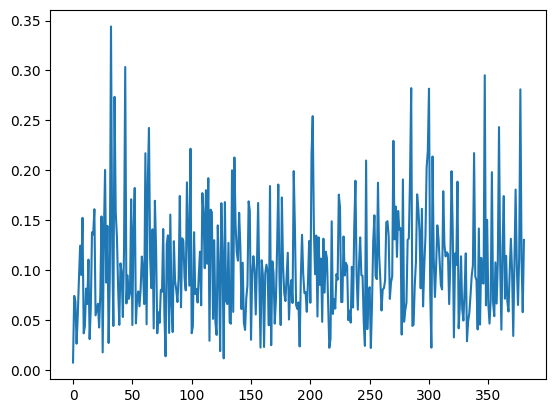

In [ ]:
import matplotlib.pyplot as plt

plt.plot(distances)

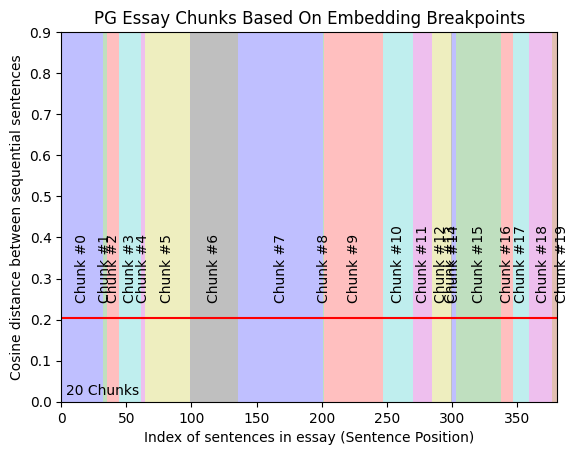

In [ ]:
import numpy as np

y_upper_bound = .9
plt.ylim(0, y_upper_bound)
plt.xlim(0, len(distances))

# We need to get the distance threshold that we'll consider an outlier
# We'll use numpy .percentile() for this
breakpoint_percentile_threshold = 95
breakpoint_distance_threshold = np.percentile(distances, breakpoint_percentile_threshold) # If you want more chunks, lower the percentile cutoff
plt.axhline(y=breakpoint_distance_threshold, color='r', linestyle='-');

# Then we'll see how many distances are actually above this one
num_distances_above_theshold = len([x for x in distances if x > breakpoint_distance_threshold]) # The amount of distances above your threshold
plt.text(x=(len(distances)*.01), y=y_upper_bound/50, s=f"{num_distances_above_theshold + 1} Chunks");

# Then we'll get the index of the distances that are above the threshold. This will tell us where we should split our text
indices_above_thresh = [i for i, x in enumerate(distances) if x > breakpoint_distance_threshold] # The indices of those breakpoints on your list

# Start of the shading and text
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
for i, breakpoint_index in enumerate(indices_above_thresh):
    start_index = 0 if i == 0 else indices_above_thresh[i - 1]
    end_index = breakpoint_index if i < len(indices_above_thresh) - 1 else len(distances)

    plt.axvspan(start_index, end_index, facecolor=colors[i % len(colors)], alpha=0.25)
    plt.text(x=np.average([start_index, end_index]),
            y=breakpoint_distance_threshold + (y_upper_bound)/ 20,
            s=f"Chunk #{i}", horizontalalignment='center',
            rotation='vertical')

# # Additional step to shade from the last breakpoint to the end of the dataset
if indices_above_thresh:
    last_breakpoint = indices_above_thresh[-1]
    if last_breakpoint < len(distances):
        plt.axvspan(last_breakpoint, len(distances), facecolor=colors[len(indices_above_thresh) % len(colors)], alpha=0.25)
        plt.text(x=np.average([last_breakpoint, len(distances)]),
                y=breakpoint_distance_threshold + (y_upper_bound)/ 20,
                s=f"Chunk #{i+1}",
                rotation='vertical')

plt.title("PG Essay Chunks Based On Embedding Breakpoints")
plt.xlabel("Index of sentences in essay (Sentence Position)")
plt.ylabel("Cosine distance between sequential sentences")
plt.show()

Well now that we've succefully distracted ourselves with a visualization, now we need to combine the sentences into chunks.

Because we have our breakpoints [23, 40, 51...] I want to make the first chunk 0-22, since the distance jumped on sentence 23.

In [ ]:
# Initialize the start index
start_index = 0

# Create a list to hold the grouped sentences
chunks = []

# Iterate through the breakpoints to slice the sentences
for index in indices_above_thresh:
    # The end index is the current breakpoint
    end_index = index

    # Slice the sentence_dicts from the current start index to the end index
    group = sentences[start_index:end_index + 1]
    combined_text = ' '.join([d['sentence'] for d in group])
    chunks.append(combined_text)

    # Update the start index for the next group
    start_index = index + 1

# The last group, if any sentences remain
if start_index < len(sentences):
    combined_text = ' '.join([d['sentence'] for d in sentences[start_index:]])
    chunks.append(combined_text)

# grouped_sentences now contains the chunked sentences

In [ ]:
chunks[0]

"October 2006\n\n(This essay is derived from a talk at MIT.)\n\nTill recently graduating seniors had two choices: get a job or go to grad school. I think there will increasingly be a third option: to start your own startup. But how common will that be? I'm sure the default will always be to get a job, but starting a startup could well become as popular as grad school. In the late 90s my professor friends used to complain that they couldn't get grad students, because all the undergrads were going to work for startups. I wouldn't be surprised if that situation returns, but with one difference: this time they'll be starting their own instead of going to work for other people's. The most ambitious students will at this point be asking: Why wait till you graduate? Why not start a startup while you're in college? In fact, why go to college at all? Why not start a startup instead? A year and a half ago I gave a talk where I said that the average age of the founders of Yahoo, Google, and Micro

In [ ]:
for i, chunk in enumerate(chunks[:2]):
    buffer = 200

    print (f"Chunk #{i}")
    print (chunk[:buffer].strip())
    print ("...")
    print (chunk[-buffer:].strip())
    print ("\n")

Chunk #0
October 2006

(This essay is derived from a talk at MIT.)

Till recently graduating seniors had two choices: get a job or go to grad school. I think there will increasingly be a third option: to start
...
m into a rush of activity. Even if you start a startup explicitly to get rich, the money you might get seems pretty theoretical most of the time. What drives you day to day is not wanting to look bad.


Chunk #1
You probably can't change that. Even if you could, I don't think you'd want to; someone who really, truly doesn't care what his peers think of him is probably a psychopath. So the best you can do is c
...
you'd want to; someone who really, truly doesn't care what his peers think of him is probably a psychopath. So the best you can do is consider this force like a wind, and set up your boat accordingly.




## Level 5: Agentic Chunking

Taking level 4 a bit further, can we give the same instruction to an LLM to do it as a human would?

But, how would a human do chunking? Based on level 4 we could follow these steps:

1. We take a sheet of paper
2. We would start with the first sentence and assume it will be the first chunk, since we don't have any other.
3. We continue reading the document and evaluating if it's a new chunk or part of the previous chunk or an existing one. If it's similar to an existing one, we concatenate it to that chunk, if not, we create a new one.
4. We continue doing this until we finish the document.

In [ ]:
text_document = documents[0].text

In [ ]:
class AgenticChunker:
    def __init__(self, llm):
        self.llm = llm

    def chunk_document(self, text: str, target_chars=2000, overlap_chars=200):
        """Split text into overlapping chunks with summaries."""
        segments = text.split("\n\n")  # Split on paragraph breaks
        full_text = " ".join(segments)
        chunks, start = [], 0

        while start < len(full_text):
            end = start + target_chars
            chunk = full_text[start:end]
            chunks.append(chunk)
            start = max(0, start + target_chars - overlap_chars)

        return [{"text": chunk, "summary": self.generate_summary(chunk)} for chunk in chunks]

    def generate_summary(self, text):
        """Get a concise summary from an LLM."""
        prompt = f"Summarize this text in one sentence:\n\n{text}"
        return self.llm.invoke(prompt)

In [ ]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model_name='gpt-4.1-mini-2025-04-14', temperature=0.2)

agentic_chunker = AgenticChunker(llm)

In [ ]:
agentics_chunks = agentic_chunker.chunk_document(text_document)

2025-10-24 19:43:14,668 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-24 19:43:16,394 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-24 19:43:17,624 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-24 19:43:18,647 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-24 19:43:19,829 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-24 19:43:20,651 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-24 19:43:21,803 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-24 19:43:22,863 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-10-24 19:43:23,825 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "

In [ ]:
pprint(agentics_chunks[0])

{'summary': AIMessage(content='The essay argues that starting a startup is becoming a viable third option for graduating seniors alongside getting a job or attending grad school, with the possibility that undergraduates might increasingly found startups even before graduation, challenging traditional career paths and societal expectations.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 47, 'prompt_tokens': 433, 'total_tokens': 480, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'fp_4c2851f862', 'id': 'chatcmpl-CUKn3xe8NVr6YVrYQIjaGlVF5oMxV', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--39ace1fa-7fc9-48a9-bbf6-ba580183b8db-0', usage_metadata={'input_tokens'

In [ ]:
from langchain_huggingface import HuggingFaceEmbeddings

embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

2025-10-24 19:43:36,449 - INFO - Use pytorch device_name: mps
2025-10-24 19:43:36,449 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2


In [ ]:
for chunk in agentics_chunks:
    chunk['embedding'] = embeddings.embed_query(chunk['text'])

In [ ]:
pprint(agentics_chunks[0])

{'embedding': [-0.04604353383183479,
               -0.08845345675945282,
               0.06487561017274857,
               -0.033981285989284515,
               0.06916138529777527,
               0.02288164757192135,
               0.0092290248721838,
               0.044321537017822266,
               0.006403755396604538,
               0.02369954250752926,
               0.024176552891731262,
               0.07340338826179504,
               -0.015368692576885223,
               -0.002451920649036765,
               0.03889230266213417,
               -0.03537219762802124,
               -0.022749781608581543,
               -0.14905335009098053,
               0.01162621658295393,
               -0.019916526973247528,
               -0.04435396194458008,
               -0.07741729170084,
               -0.03507914021611214,
               -0.02021920680999756,
               0.07026306539773941,
               0.042740728706121445,
               0.0034428532235324383,
        

# Text processing



### Tokenization, POS and Dependency Parsing

In [ ]:
$ pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.8.0/en_core_web_sm-3.8.0.tar.gz

In [ ]:
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

file_path = (
    "data/Regulaciones cacao y chocolate 2003.pdf"
)
loader = PyPDFLoader(file_path)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = text_splitter.split_documents(docs)

In [ ]:
pprint(splits[0].page_content)

('Status:  This is the original version (as it was originally made).\n'
 'STATUTORY INSTRUMENTS\n'
 '2003 No. 1659\n'
 'FOOD, ENGLAND\n'
 'The Cocoa and Chocolate Products (England) Regulations 2003\n'
 'Made       -      -      -      - 25th June 2003\n'
 'Laid before Parliament 3rd July 2003\n'
 'Coming into force       -      - 3rd August 2003\n'
 'The Secretary of State, in exercise of the powers conferred by sections '
 '16(1)(e), 17(1), 26(1) and (3)\n'
 'and 48(1) of the Food Safety Act 1990(1) and now vested in him(2) and of all '
 'other powers enabling\n'
 'him in that behalf, having had regard in accordance with section 48(4A) of '
 'that Act to relevant\n'
 'advice given by the Food Standards Agency, and after consultation both as '
 'required by Article 9\n'
 'of Regulation (EC) No. 178/2002 of the European Parliament and of the '
 'Council laying down the\n'
 'general principles and requirements of food law, establishing the European '
 'Food Safety Authority\n'
 'and lay

In [ ]:
import spacy
import en_core_web_sm

nlp = en_core_web_sm.load()
single_doc = nlp(splits[0].page_content)

In [ ]:
def tokenize_text(doc):
    return[
        {
            "text": token.text,
            "position": token.pos_, #part of speech
            "dep": token.dep_, #dependency relation
        }
        for token in doc
    ]

## Token Analysis Function

The `tokenize_text` function extracts linguistic information from a spaCy-processed document:

**Purpose**: Convert spaCy tokens into structured data for text analysis and processing.

**Input**: A spaCy `Doc` object (processed text document)

**Output**: List of dictionaries, where each dictionary contains:

- **`"text"`**: The actual word or punctuation mark (e.g., "The", "cat", ".")
- **`"position"`**: Part-of-speech tag indicating grammatical role:
  - `"DET"` = Determiner (the, a, an)
  - `"NOUN"` = Noun (cat, house, idea)
  - `"VERB"` = Verb (run, think, is)
  - `"ADJ"` = Adjective (quick, beautiful)
  - `"PUNCT"` = Punctuation (., !, ?)
- **`"dep"`**: Dependency relationship showing how words connect:
  - `"det"` = Determiner relationship
  - `"nsubj"` = Nominal subject
  - `"amod"` = Adjectival modifier
  - `"punct"` = Punctuation

**Example Output**:
```python
[
    {'text': 'The', 'position': 'DET', 'dep': 'det'},
    {'text': 'quick', 'position': 'ADJ', 'dep': 'amod'},
    {'text': 'fox', 'position': 'NOUN', 'dep': 'nsubj'},
    {'text': '.', 'position': 'PUNCT', 'dep': 'punct'}
]
```

This structured representation enables intelligent text processing for chunking strategies that preserve linguistic meaning.

In [ ]:
for token in tokenize_text(single_doc):
    print(token)

{'text': 'Status', 'position': 'NOUN', 'dep': 'dep'}
{'text': ':', 'position': 'PUNCT', 'dep': 'punct'}
{'text': ' ', 'position': 'SPACE', 'dep': 'dep'}
{'text': 'This', 'position': 'PRON', 'dep': 'nsubj'}
{'text': 'is', 'position': 'AUX', 'dep': 'ROOT'}
{'text': 'the', 'position': 'DET', 'dep': 'det'}
{'text': 'original', 'position': 'ADJ', 'dep': 'amod'}
{'text': 'version', 'position': 'NOUN', 'dep': 'attr'}
{'text': '(', 'position': 'PUNCT', 'dep': 'punct'}
{'text': 'as', 'position': 'SCONJ', 'dep': 'mark'}
{'text': 'it', 'position': 'PRON', 'dep': 'nsubjpass'}
{'text': 'was', 'position': 'AUX', 'dep': 'auxpass'}
{'text': 'originally', 'position': 'ADV', 'dep': 'advmod'}
{'text': 'made', 'position': 'VERB', 'dep': 'advcl'}
{'text': ')', 'position': 'PUNCT', 'dep': 'punct'}
{'text': '.', 'position': 'PUNCT', 'dep': 'punct'}
{'text': '\n', 'position': 'SPACE', 'dep': 'dep'}
{'text': 'STATUTORY', 'position': 'PROPN', 'dep': 'compound'}
{'text': 'INSTRUMENTS', 'position': 'NOUN', 'dep':

### Stopwords removal


In [ ]:
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS

def remove_stopwords(doc):
    return [token for token in doc if token.text.lower() not in spacy_stopwords]

filtered_tokens = remove_stopwords(single_doc)

In [ ]:
# Print the first few filtered tokens to verify
for token in filtered_tokens[:10]:
    print(token.text)

Status
:
 
original
version
(
originally
)
.




### Stemming

In [ ]:
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()

#example
text = "running runners run easily jumper jumps jumping"

doc = nlp(text)

# apply stemming
stemmed_tokens = [stemmer.stem(token.text) for token in doc]

stem_text = " ".join(stemmed_tokens)

print("original text", text)
print("stemmed text", stem_text)

original text running runners run easily jumper jumps jumping
stemmed text run runner run easili jumper jump jump


### Lemmatization

In [ ]:
def lemmatize_text(doc):
    return [token.lemma_ for token in doc]

lemmatized_tokens = lemmatize_text(single_doc)
print(lemmatized_tokens[:10])

['status', ':', ' ', 'this', 'be', 'the', 'original', 'version', '(', 'as']
